In [1]:
%env CUDA_VISIBLE_DEVICES=

env: CUDA_VISIBLE_DEVICES=


In [2]:
fig_scale = 1.#2./3.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp
import h5py

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

from time import time
import json

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform

In [4]:
plt.rcParams['font.size'] = 14

In [5]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    N_chains = 1

print(jax.devices())    

[CpuDevice(id=0)]


# Process Data

In [6]:
IRD = transform.IRD(min_confirmed=0, min_recovered=0, min_deaths=20)

[265, 252, 91]


In [7]:
IRD[2]

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,30,30,30,33,36,36,40,42,43,47
Albania,0,0,0,0,0,0,0,0,0,0,...,26,26,26,26,26,26,27,27,27,27
Algeria,0,0,0,0,0,0,0,0,0,0,...,348,364,367,375,384,392,402,407,415,419
Andorra,0,0,0,0,0,0,0,0,0,0,...,33,35,35,36,37,37,37,37,40,40
Argentina,0,0,0,0,0,0,0,0,0,0,...,115,123,129,132,136,147,152,165,176,185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
US,0,0,0,0,0,0,0,0,0,0,...,32930,36787,38664,40661,42094,44444,46622,49954,51949,53755
Mali,0,0,0,0,0,0,0,0,0,0,...,13,13,13,14,14,14,17,21,21,21
Australia,0,0,0,0,0,0,0,0,0,0,...,63,66,67,67,67,67,67,75,79,80


In [8]:
deaths = {}
start_days = np.argmax((IRD[2].values>3),axis=1)
end_days = np.argmax((IRD[2].values>1000), axis=1)
for i, country in enumerate(IRD[2].index):
    if 'China' in country:
        continue
    if len(IRD[2].T[country].values[start_days[i]:])>10 and start_days[i]>0:
        if end_days[i]>0:
            deaths[country] = IRD[2].T[country].values[start_days[i]:end_days[i]]
        else:
            deaths[country] = IRD[2].T[country].values[start_days[i]:]

In [9]:
samples = {}
with h5py.File('../data/nb_samples/4.1.0.1_STEP_EXP_Independent_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]

In [10]:
countries = onp.loadtxt('../data/nb_samples/4.1.0.1_STEP_EXP_Independent_countries.txt', 
                        delimiter='|', dtype=str)[:,0]
t0 = np.mean(samples['t0'], axis=0)
t0_dict = dict(zip(countries, t0.astype(np.int32)))

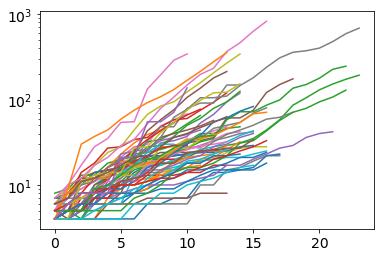

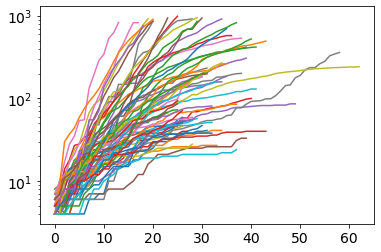

In [11]:
for c in countries[t0>10]:
    plt.semilogy(deaths[c][:t0_dict[c]])
plt.figure()
for c in countries[t0>10]:
    plt.semilogy(deaths[c])

In [12]:
countries[t0>10], len(countries[t0>10])

(array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Argentina',
        'Australia / New South Wales', 'Austria', 'Belarus', 'Bolivia',
        'Bosnia and Herzegovina', 'Bulgaria', 'Burkina Faso',
        'Canada / Alberta', 'Canada / British Columbia',
        'Canada / Ontario', 'Canada / Quebec', 'Chile', 'Colombia',
        'Congo (Kinshasa)', 'Croatia', 'Cuba', 'Czechia', 'Denmark',
        'Ecuador', 'Egypt', 'Estonia', 'Finland', 'France', 'Germany',
        'Greece', 'Honduras', 'Hungary', 'India', 'Iran', 'Iraq', 'Israel',
        'Italy', 'Japan', 'Korea, South', 'Lebanon', 'Lithuania',
        'Luxembourg', 'Mexico', 'Moldova', 'Morocco', 'Netherlands',
        'North Macedonia', 'Norway', 'Pakistan', 'Panama', 'Peru',
        'Philippines', 'Poland', 'San Marino', 'Slovenia', 'South Africa',
        'Spain', 'Sweden', 'Switzerland', 'Thailand', 'Tunisia', 'Turkey',
        'Ukraine', 'United Arab Emirates', 'United Kingdom', 'US'],
       dtype='<U27'), 66)

In [13]:
bcg_cov_est = json.load(open('BCG_Coverage_Estimates.json', 'r'))

In [14]:
bcg_cov_countries = list(set(deaths.keys()).intersection(bcg_cov_est.keys()).intersection(countries[t0>10]))
set(deaths.keys())-set(bcg_cov_countries), len(bcg_cov_countries), len(deaths)

({'Armenia',
  'Australia',
  'Azerbaijan',
  'Bangladesh',
  'Belgium',
  'Bolivia',
  'Brazil',
  'Cameroon',
  'Canada',
  'Congo (Kinshasa)',
  'Dominican Republic',
  'Indonesia',
  'Ireland',
  'Kazakhstan',
  'Malaysia',
  'Mali',
  'Moldova',
  'Niger',
  'Nigeria',
  'Portugal',
  'Romania',
  'Russia',
  'San Marino',
  'Saudi Arabia',
  'Serbia',
  'United Kingdom / Channel Islands'},
 62,
 88)

In [15]:
len(deaths)

88

In [16]:
deaths.keys()

dict_keys(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Argentina', 'Armenia', 'Australia / New South Wales', 'Austria', 'Azerbaijan', 'Bangladesh', 'Belarus', 'Belgium', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Cameroon', 'Canada / Alberta', 'Canada / British Columbia', 'Canada / Ontario', 'Canada / Quebec', 'Chile', 'Colombia', 'Congo (Kinshasa)', 'Croatia', 'Cuba', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Honduras', 'Hungary', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kazakhstan', 'Korea, South', 'Lebanon', 'Lithuania', 'Luxembourg', 'Malaysia', 'Mexico', 'Moldova', 'Morocco', 'Netherlands', 'Niger', 'Nigeria', 'North Macedonia', 'Norway', 'Pakistan', 'Panama', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino', 'Saudi Arabia', 'Serbia', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thaila

In [17]:
len(bcg_cov_countries)

62

In [18]:
all_countries = list(set(deaths.keys()).intersection(bcg_cov_countries))

In [19]:
len(all_countries)

62

In [20]:
with h5py.File('../data/nb_samples/4.1.1.8.4_INCL_BLOOD_MultiVariate_Regression_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[key][()]

In [21]:
set()-set(all_countries)

set()

In [22]:
all_countries = [c.decode() for c in samples['countries']]

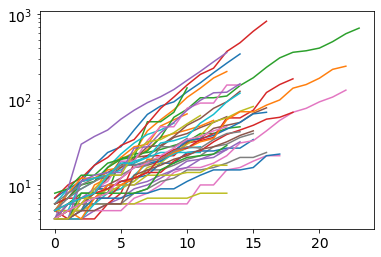

In [23]:
for c in all_countries:
    plt.semilogy(deaths[c][:t0_dict[c]])

In [24]:
t0_dict[c]

15

In [25]:
len(all_countries), all_countries

(40,
 ['Germany',
  'Netherlands',
  'United Kingdom',
  'Italy',
  'Thailand',
  'US',
  'Japan',
  'Slovenia',
  'Australia / New South Wales',
  'Czechia',
  'South Africa',
  'Austria',
  'Canada / Alberta',
  'Canada / Quebec',
  'Turkey',
  'Colombia',
  'Poland',
  'Cuba',
  'Peru',
  'Argentina',
  'Philippines',
  'Israel',
  'Sweden',
  'Norway',
  'Hungary',
  'Mexico',
  'France',
  'Korea, South',
  'Canada / British Columbia',
  'Estonia',
  'Lithuania',
  'India',
  'Luxembourg',
  'Pakistan',
  'Switzerland',
  'Greece',
  'Chile',
  'Finland',
  'Denmark',
  'Canada / Ontario'])

# Bayesian Model

In [26]:
def normalHP(name, mean, std, N_child):

    # Group mean
    grp_mean = numpyro.sample(str(name)+'_grp_mean', dist.Normal(mean, std))
    # Group variance
    grp_sigma = numpyro.sample(str(name)+'_grp_sigma', dist.HalfNormal(std))
    # Individual param
#     ind = numpyro.sample(str(name)+'_ind', 
#                          dist.TransformedDistribution(dist.Normal(0.0*np.ones(N_child), 1.0*np.ones(N_child)), 
#                                                       dist.transforms.AffineTransform(grp_mean, grp_sigma)))
    ind = numpyro.sample(str(name)+'_ind', dist.Normal(grp_mean*np.ones(N_child), grp_sigma*np.ones(N_child)))
    
    return ind

In [27]:
def model():
    
    N = len(all_countries)
    
    Di = normalHP('Di', 7.0, 3.0, N)
    GR = normalHP('GR', 1.2, 0.2, N)
    alpha = numpyro.sample('alpha', dist.Normal(0.0, 0.01))

    # Create likelihood for each country    
    for i, country in enumerate(all_countries):
        dead = deaths[country][:t0_dict[country]]
        t = np.arange(len(dead))
        prediction = Di[i]*(GR[i]+alpha*bcg_cov_est[country])**t
        numpyro.sample(country, dist.Poisson(prediction), # Exponential regression
                       obs=dead)

In [28]:
N = len(all_countries)

scale = 0.5

init_params = {'Di_grp_mean': 7.0*np.ones((N_chains, 1)) + 3.0*scale*onp.random.randn(N_chains, 1),
               'GR_grp_mean': 1.2*np.ones((N_chains, 1)) + 0.2*scale*onp.random.randn(N_chains, 1),
               'Di_grp_sigma': 0.0*np.ones((N_chains, 1)) + 0.1*np.abs(scale*onp.random.randn(N_chains, 1)),
               'GR_grp_sigma': 0.0*np.ones((N_chains, 1)) + 0.1*np.abs(scale*onp.random.randn(N_chains, 1)),
               'Di_ind': 7.0*np.ones((N_chains, N)) + 3.0*scale*onp.random.randn(N_chains, N),
               'GR_ind': 1.2*np.ones((N_chains, N)) + 0.2*scale*onp.random.randn(N_chains, N),
               'alpha': 0.0*np.ones((N_chains, 1)) + 0.01*scale*onp.random.randn(N_chains, 1),
              }
if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=10000, num_chains=N_chains)
rng_key = random.PRNGKey(0)

In [29]:
s = time()
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)
print(f'Time taken to compile model and draw samples : {time()-s} s')

Time taken to compile model and draw samples : 25514.27240729332 s


In [9]:
samples = mcmc.get_samples()
with h5py.File('../data/nb_samples/4.1.1.11_BCG_Regression_samples.h5', 'w') as fp:
    for key in samples.keys():
        fp[key] = samples[key]
    fp['potential_energy'] = mcmc.get_extra_fields()['potential_energy']
mcmc.print_summary()

In [10]:
samples = {}
with h5py.File('../data/nb_samples/4.1.1.11_BCG_Regression_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]

In [31]:
sum([t0_dict[c] for c in all_countries])

613

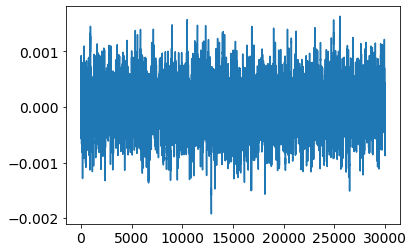

In [32]:
plt.plot(samples['alpha'][10000:])

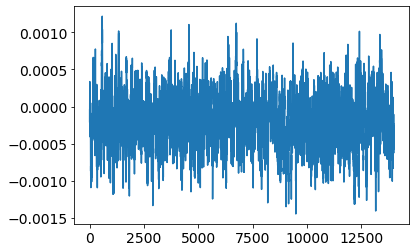

In [21]:
plt.plot(samples['alpha'])

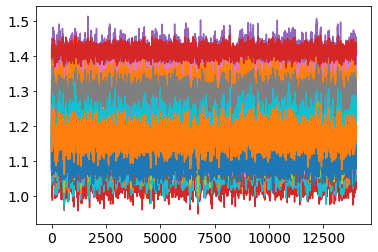

In [22]:
plt.plot(samples['GR_ind']);

In [36]:
len(t0)

78

In [38]:
2*(np.sum(t0.astype(np.int32))-(2*len(t0)+2+1))

DeviceArray(1828, dtype=int32)

Text(0.5, 0, 'Coefficient for BCG Vaccine Coverage [per % per day]')

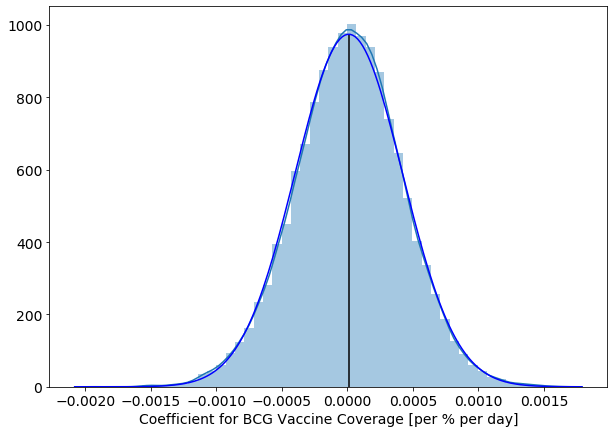

In [34]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
sns.distplot(samples['alpha'][10000:], bins=50, fit=norm, 
             fit_kws={'color':'blue'}, color='tab:blue', label=r'$alpha')
plt.vlines(np.mean(samples['alpha'][10000:]), 0, norm.pdf(np.mean(samples['alpha'][10000:]), *norm.fit(samples['alpha'][10000:])))
plt.xlabel('Coefficient for BCG Vaccine Coverage [per % per day]')

Text(0.5, 0, 'Coefficient for BCG Vaccine Coverage [per % per day]')

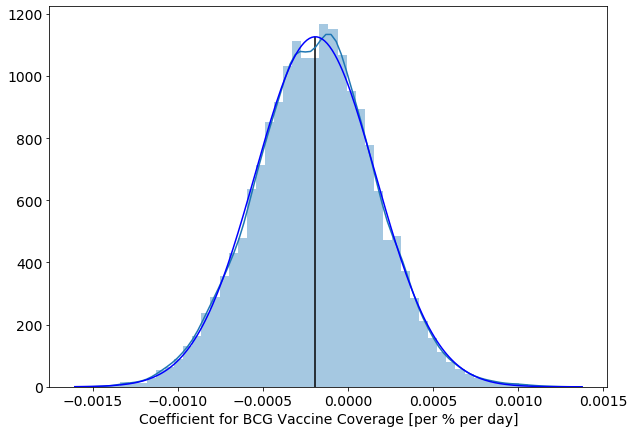

In [26]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
sns.distplot(samples['alpha'], bins=50, fit=norm, 
             fit_kws={'color':'blue'}, color='tab:blue', label=r'$alpha')
plt.vlines(np.mean(samples['alpha']), 0, norm.pdf(np.mean(samples['alpha']), *norm.fit(samples['alpha'])))
plt.xlabel('Coefficient for BCG Vaccine Coverage [per % per day]')

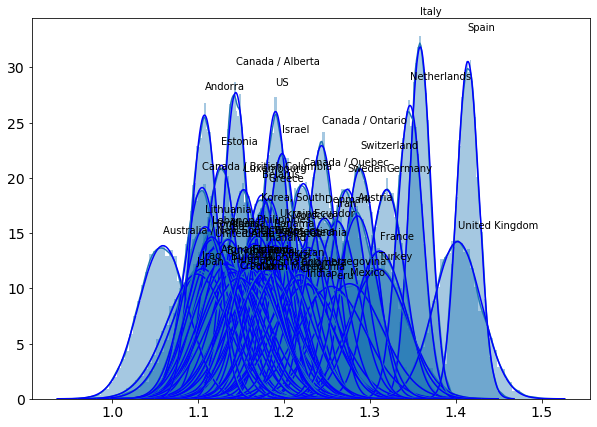

In [27]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(bcg_cov_countries):
    mn = np.mean(samples['GR_ind'][:,i])
    std = np.std(samples['GR_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10, verticalalignment='center')
    sns.distplot(samples['GR_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'blue'}, color='tab:blue')

# Example Plots

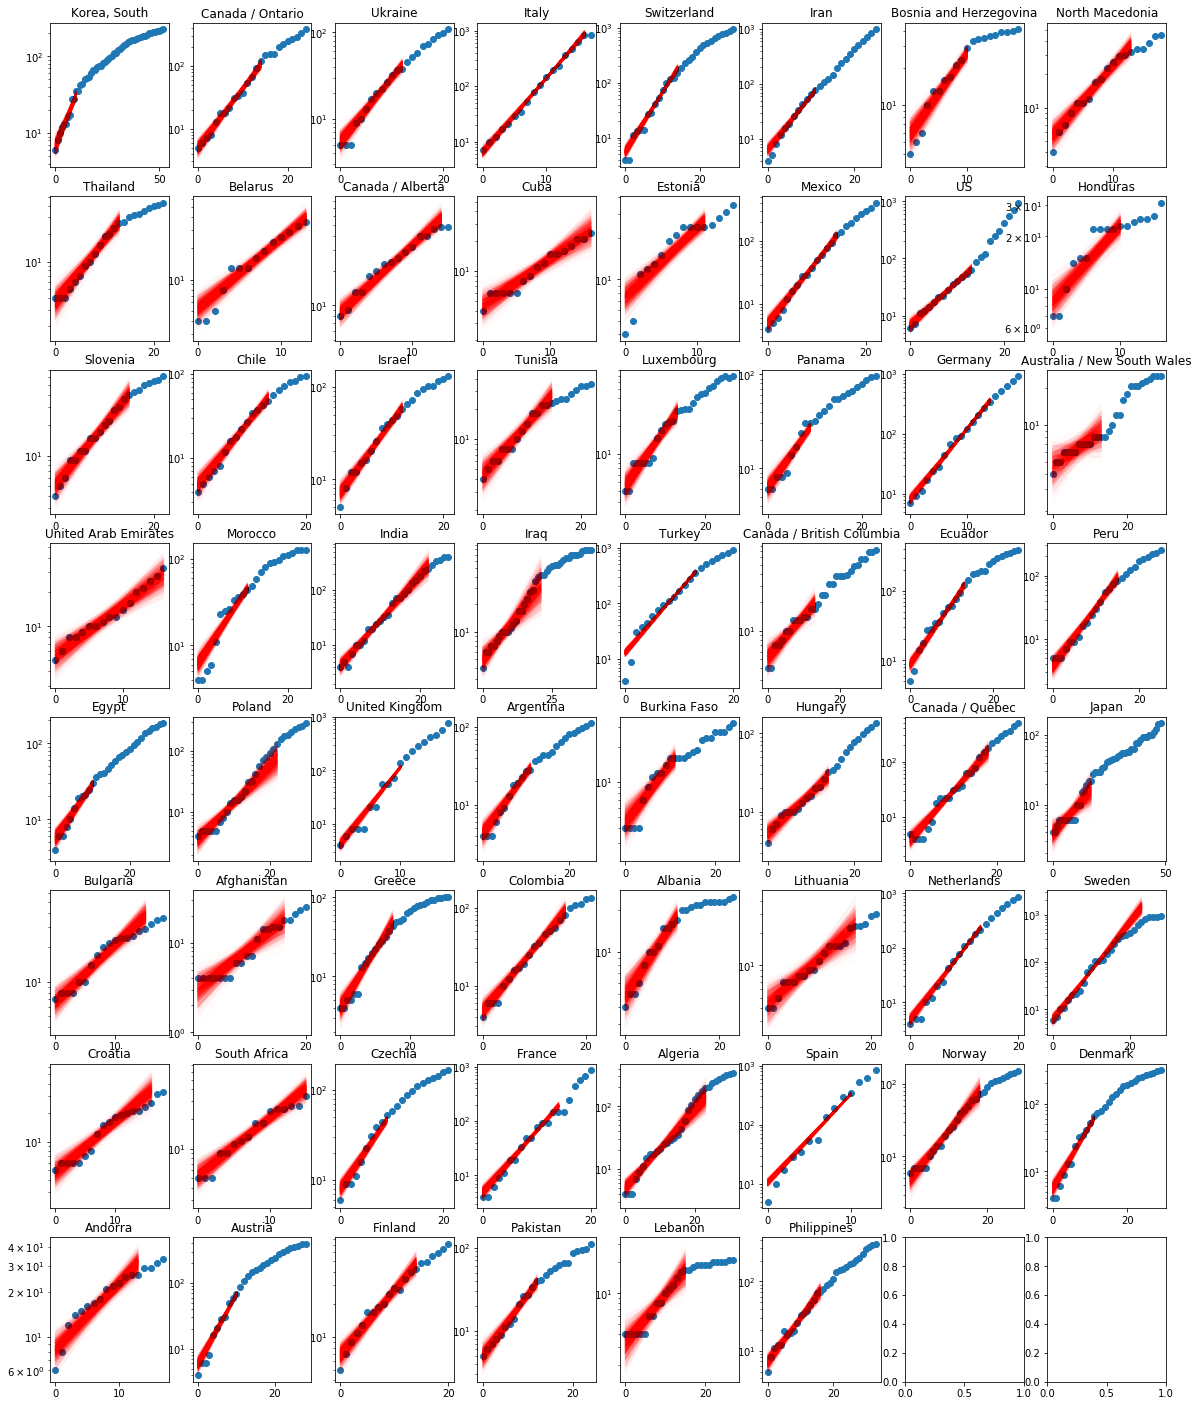

In [25]:
plt.rcParams['font.size'] = 10
fig,ax = plt.subplots(8, 8, figsize=(fig_scale*20,fig_scale*25))
a = ax.flatten()
for i, c in enumerate(bcg_cov_countries):
    t = np.arange(len(deaths[c]))[:t0_dict[c]]
    a[i].set_title(c)
    a[i].semilogy(deaths[c], 'o')
    a[i].semilogy((samples['Di_ind'][::10,i:i+1]*(samples['GR_ind'][::10,i:i+1]+samples['alpha'][::10]*bcg_cov_est[c])**t[None,:]).T, 'r', alpha=0.01)
    
# plt.savefig('../plots/4.1_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14

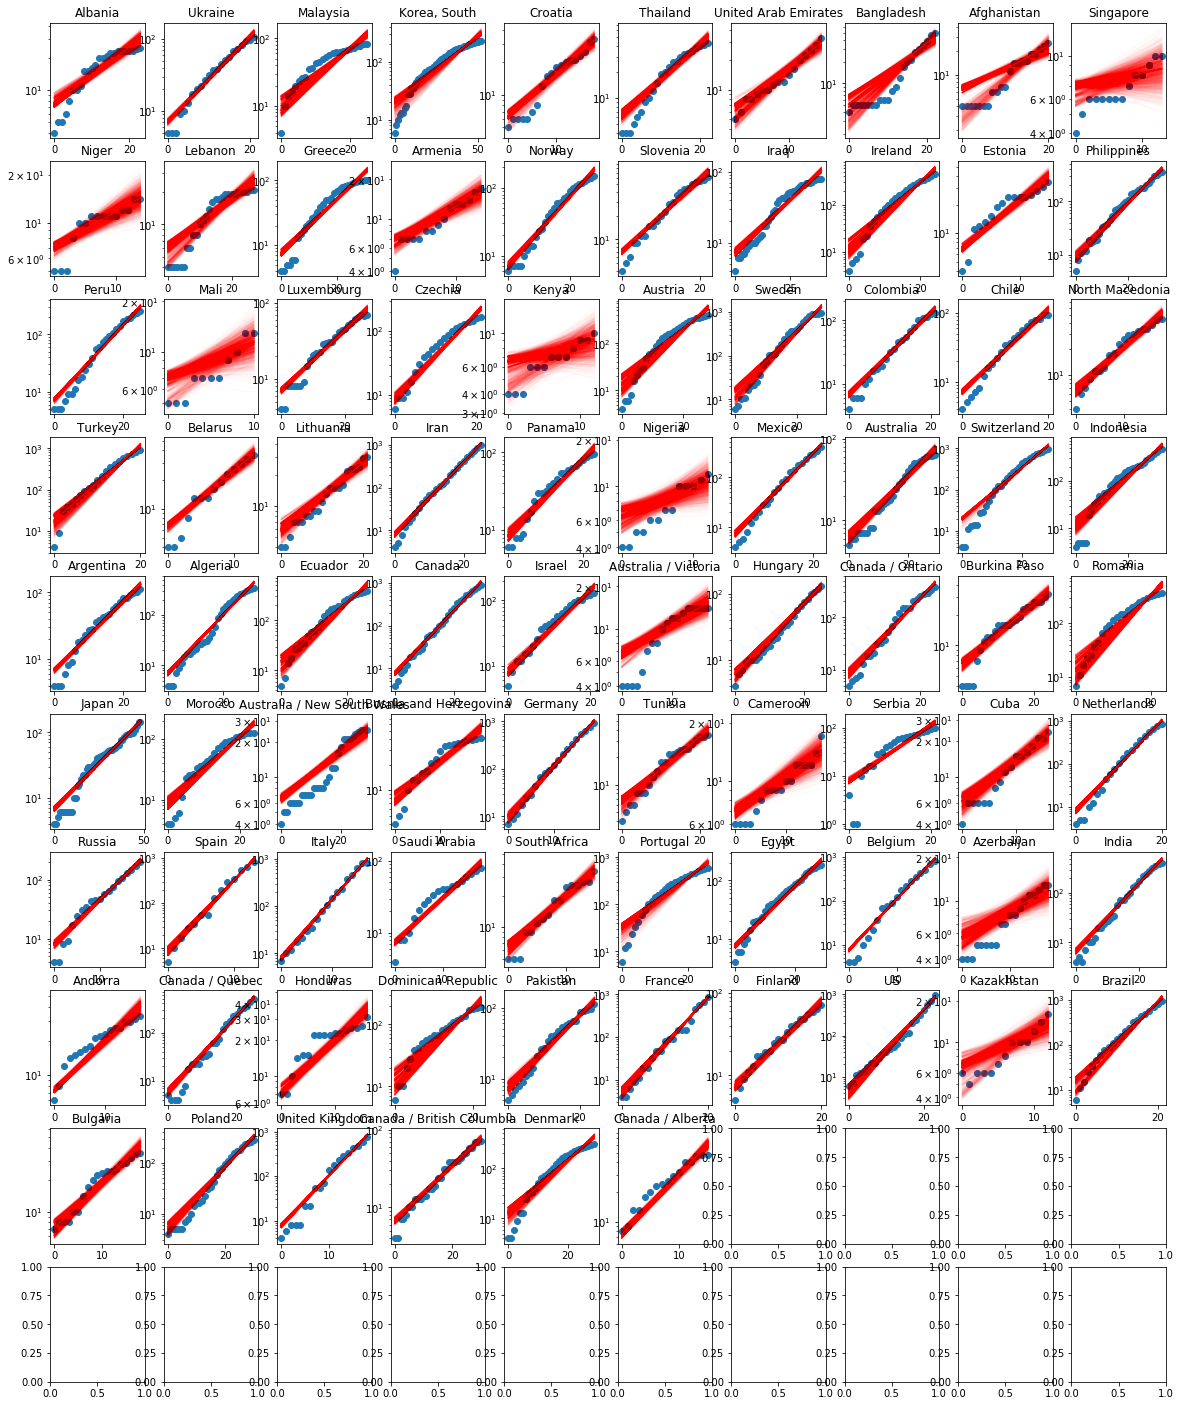

In [25]:
plt.rcParams['font.size'] = 10
fig,ax = plt.subplots(10, 10, figsize=(fig_scale*20,fig_scale*25))
a = ax.flatten()
for i, c in enumerate(bcg_cov_countries):
    t = np.arange(len(deaths[c]))
    a[i].set_title(c)
    a[i].semilogy(deaths[c], 'o')
    a[i].semilogy(np.mean(samples['Di_ind'][:,i])*(np.mean(samples['GR_ind'][:,i])+np.mean(samples['alpha'])*bcg_cov_est[c])**t, 'r')
    a[i].semilogy((samples['Di_ind'][::10,i:i+1]*(samples['GR_ind'][::10,i:i+1]+samples['alpha'][::10]*bcg_cov_est[c])**t[None,:]).T, 'r', alpha=0.01)
    
# plt.savefig('../plots/4.1_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14

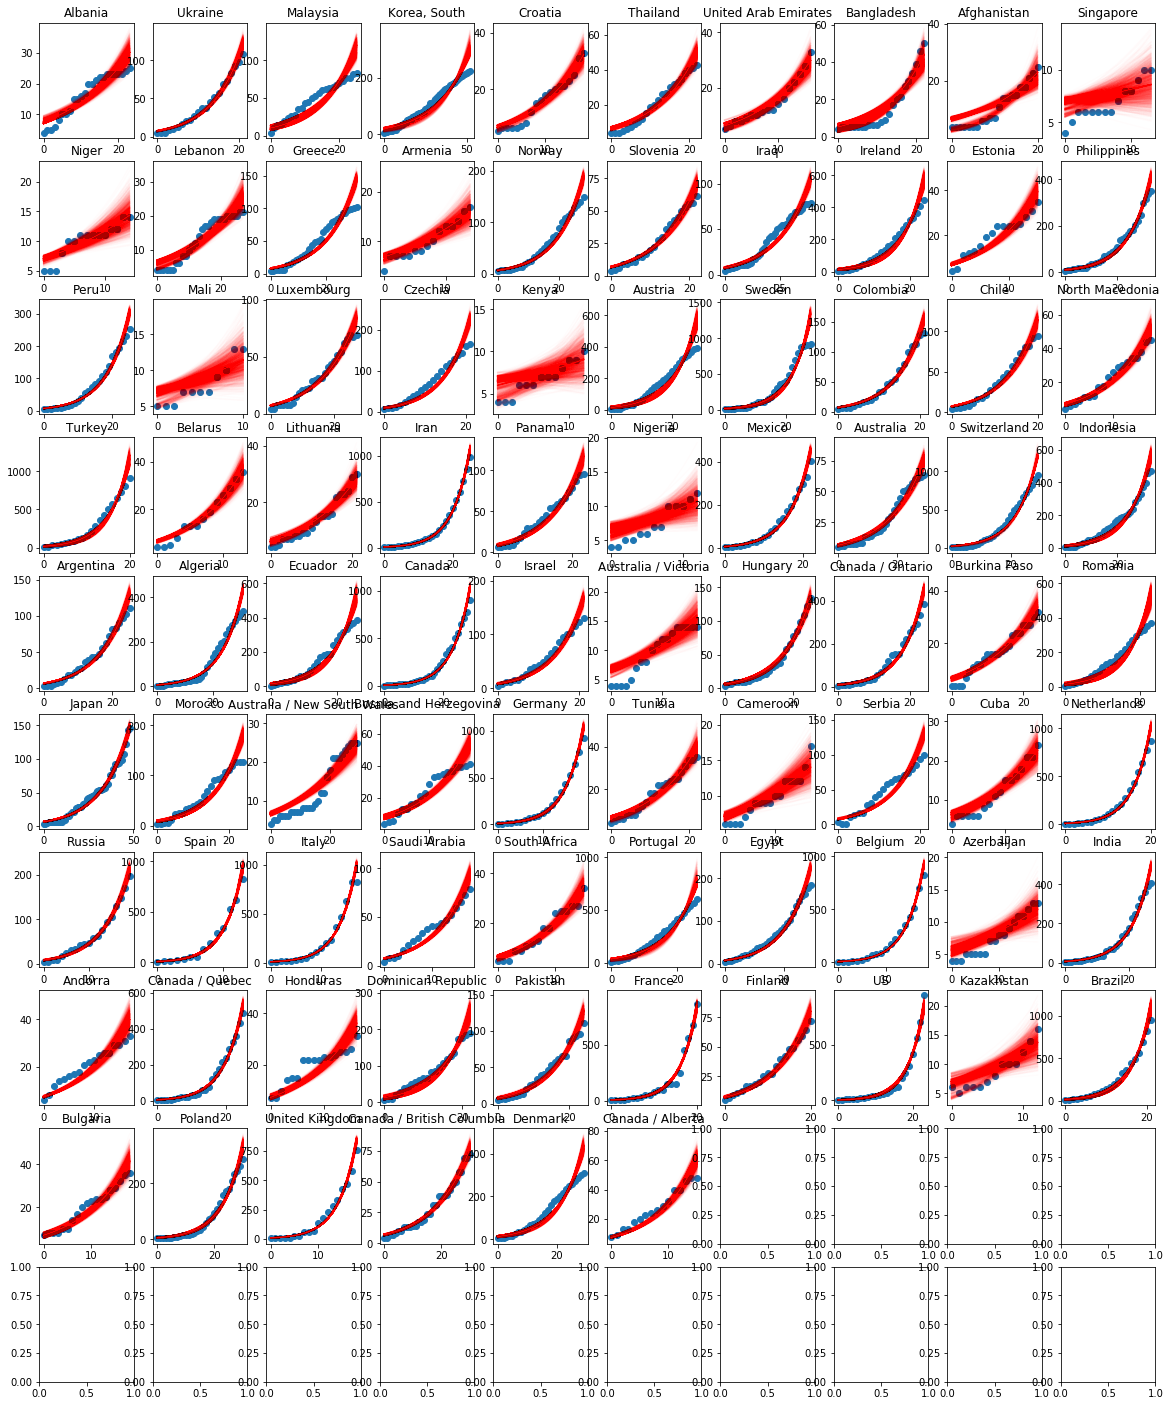

In [28]:
plt.rcParams['font.size'] = 10
fig,ax = plt.subplots(10, 10, figsize=(fig_scale*20,fig_scale*25))
a = ax.flatten()
for i, c in enumerate(bcg_cov_countries):
    t = np.arange(len(deaths[c]))
    a[i].set_title(c)
    a[i].plot(deaths[c], 'o')
    a[i].plot(np.mean(samples['Di_ind'][:,i])*(np.mean(samples['GR_ind'][:,i])+np.mean(samples['alpha'])*bcg_cov_est[c])**t, 'r')
    a[i].plot((samples['Di_ind'][::10,i:i+1]*(samples['GR_ind'][::10,i:i+1]+samples['alpha'][::10]*bcg_cov_est[c])**t[None,:]).T, 'r', alpha=0.01)
    
# plt.savefig('../plots/4.1_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14

# Trace Plots

Text(0, 0.5, 'Growth Rate')

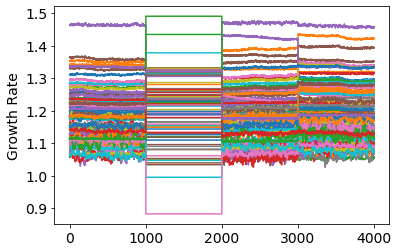

In [35]:
plt.plot(samples['GR_ind'])
plt.ylabel('Growth Rate')

ValueError: x and y can be no greater than 2-D, but have shapes (4,) and (4, 1000, 86)

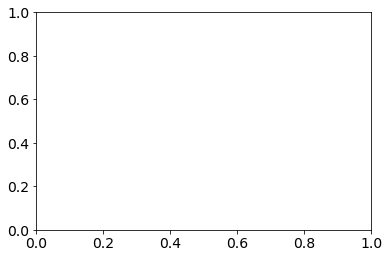

In [41]:
plt.plot(samples['Di_ind'])
plt.ylabel('Initial Deaths')

In [64]:
x = np.linspace(0, 300, 600)

In [67]:
dexp = lambda a, b, x: a*np.exp(np.exp(-b*x)*x)

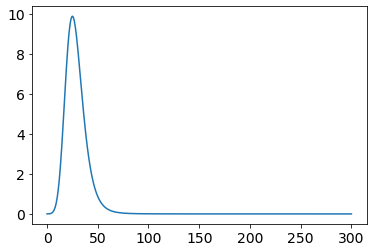

In [69]:
plt.plot(x, dexp(1e-3, 4e-2, x))